In [124]:
# %%capture
# %run final_chars_classification.ipynb



In [125]:
%run table_detector.ipynb

In [126]:
%run final_functions.ipynb

In [127]:
%run preprocessing.ipynb

In [128]:
%run get_rows_number.ipynb

In [129]:
# initialize_models(True)
load_models()

In [130]:
from tabular import tabular
import math

In [131]:
def solve_expression(img, is_table = False, showTrace = False):
    
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    if(is_table):
        # show_images([table_tany(img)])
        # table_tany(img) 
        
        img = table_preprocessing(img, showTrace)
        if showTrace:
            show_images([img])

        cells, col_num, row_num = box_extraction(img, showTrace)#, table= True)

        letters = [classify(i, is_letter=True, is_table=is_table) for i in cells[0:col_num]]
        
        numbers = [classify(i, is_0_1=True, is_table=is_table) for i in cells[col_num:]]
        
        for i in  cells[col_num:]:
            show_images([i])
            print("out", classify(i, is_0_1=True, is_table=is_table))
        
        numbers = [int(i) for i in numbers]
        
        if True:
            print(letters)
            print(numbers)
            print('rows numbers ' + str(row_num))
            print('cols numbers ' + str(col_num))
        
        
        solver = tabular.McCluskey()
        num_outputs = col_num-int(math.log(row_num-1,2))
        print(f"num_outputs: {num_outputs}")
        solver.solve(cells=numbers, num_col=col_num, num_outputs=num_outputs)

    else: 

        img = expression_preprocessing(img, showTrace)
        if showTrace:
            show_images([img])

        expression_rows = get_rows_number(img, showTrace= showTrace)
        
        if showTrace:
            print("ROWS")
            show_images(expression_rows)
        expressions = [classify(i, is_expression=True, verbose=showTrace) for i in expression_rows ]
        
        if showTrace: print(expressions)
        result = []
        for ex in expressions:
            try:
                ex[1] ='='
                result.append(get_table(ex))
            except:
                result.append('error')
        
        for r in result:
            print(r)

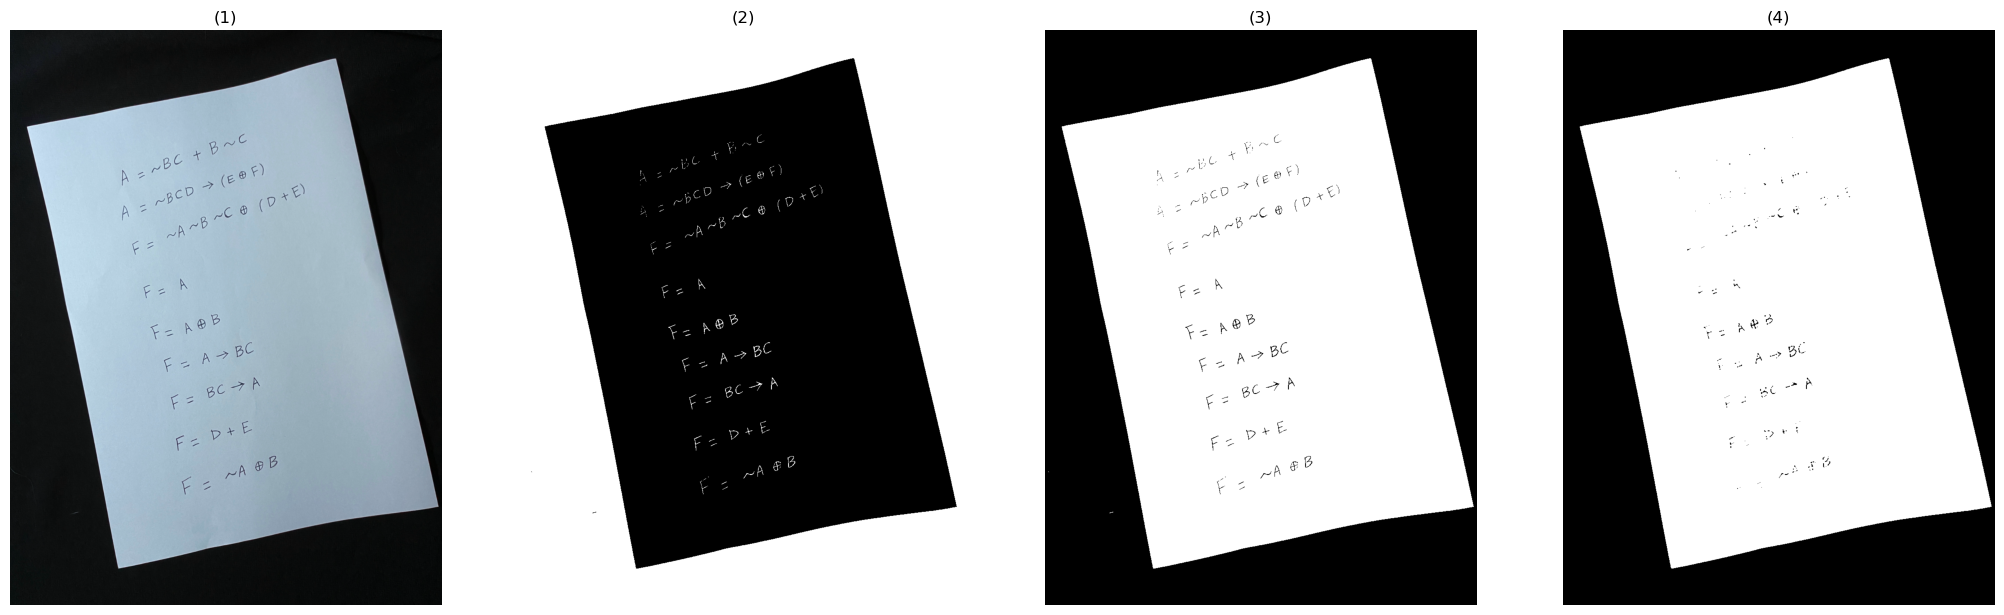

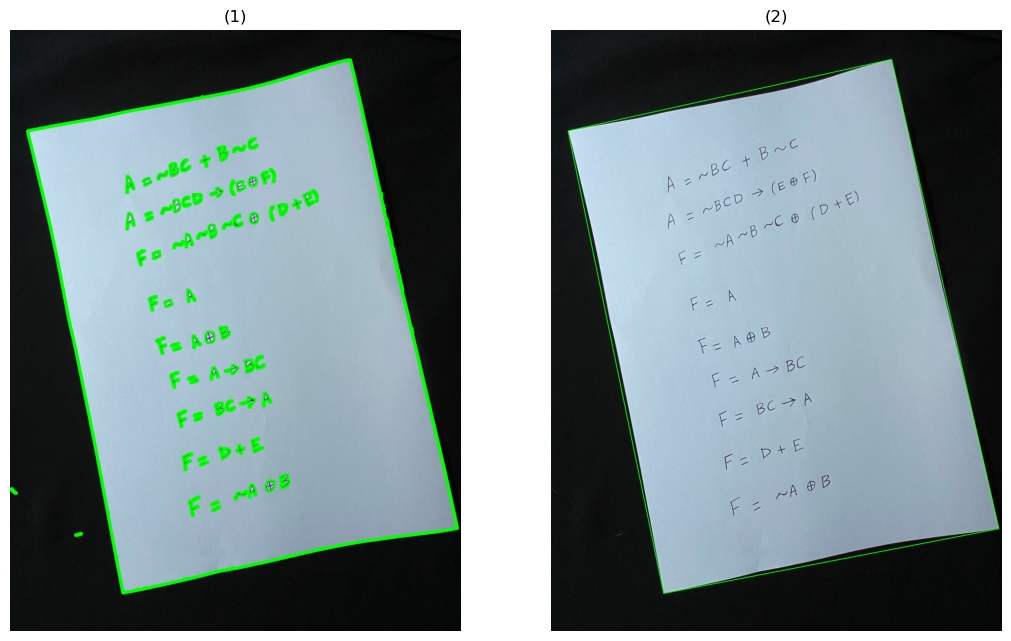

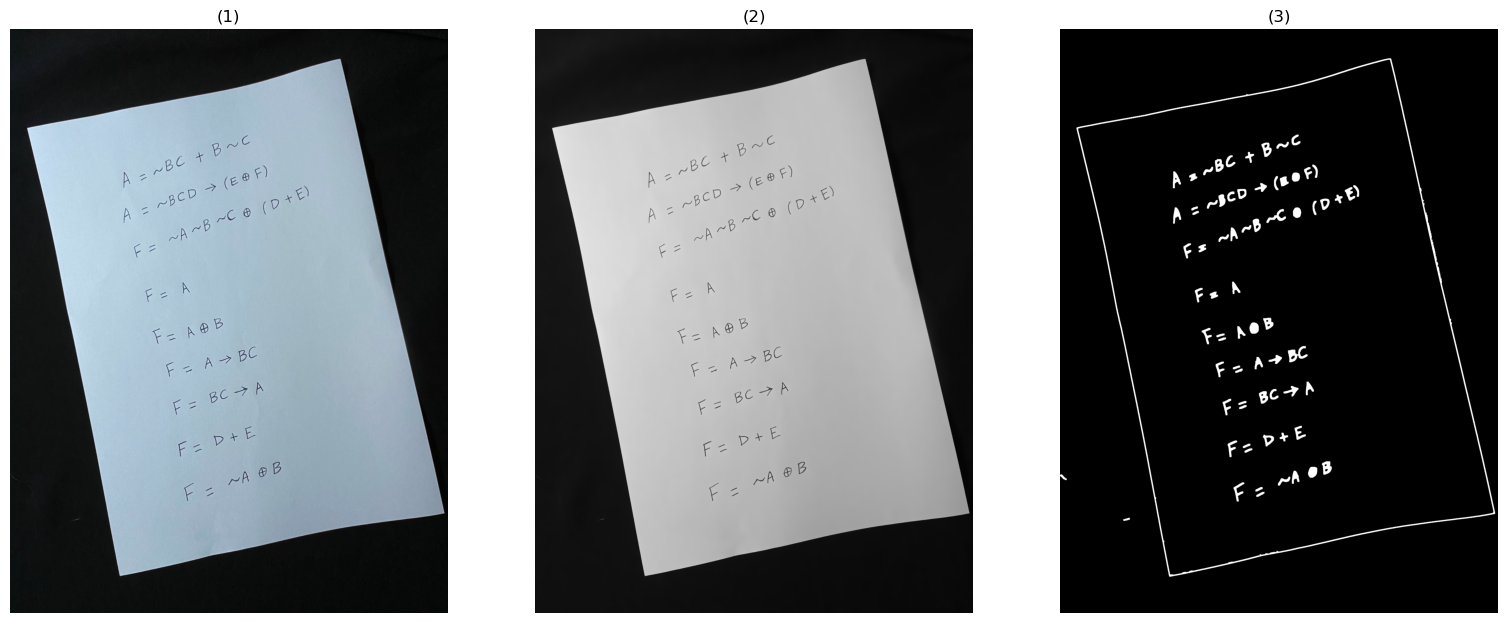

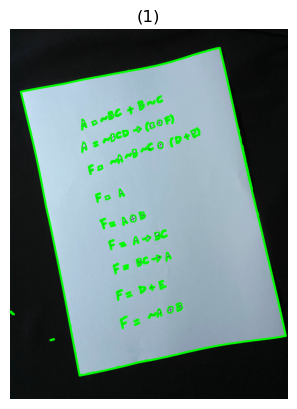

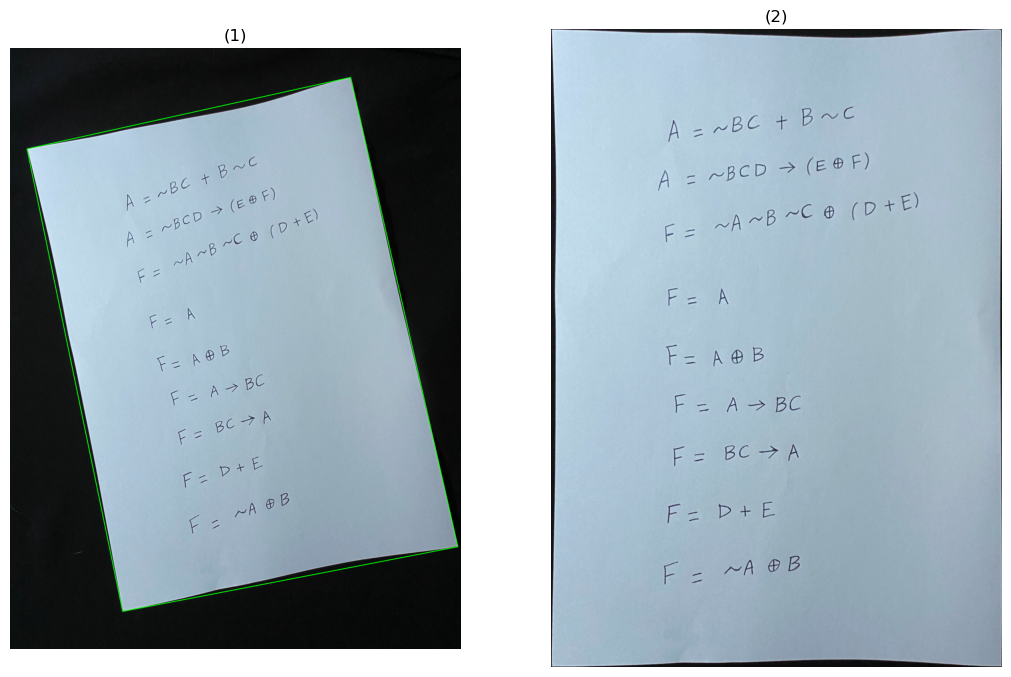

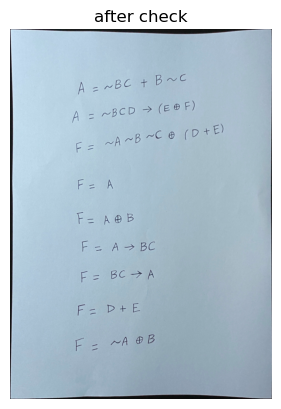

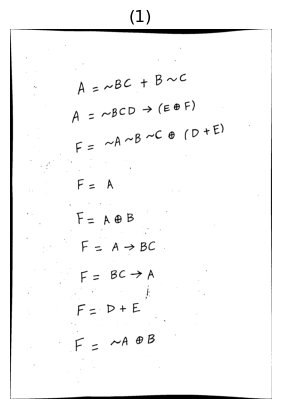

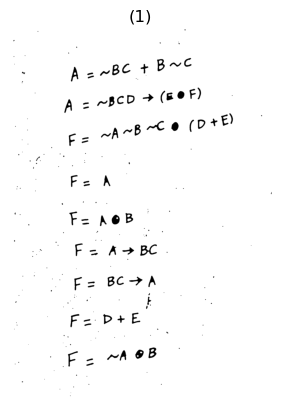

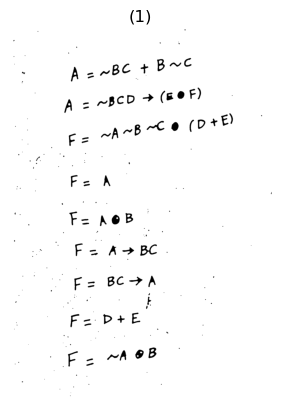

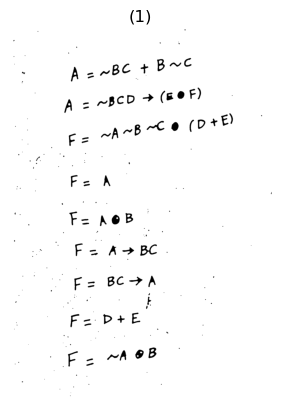

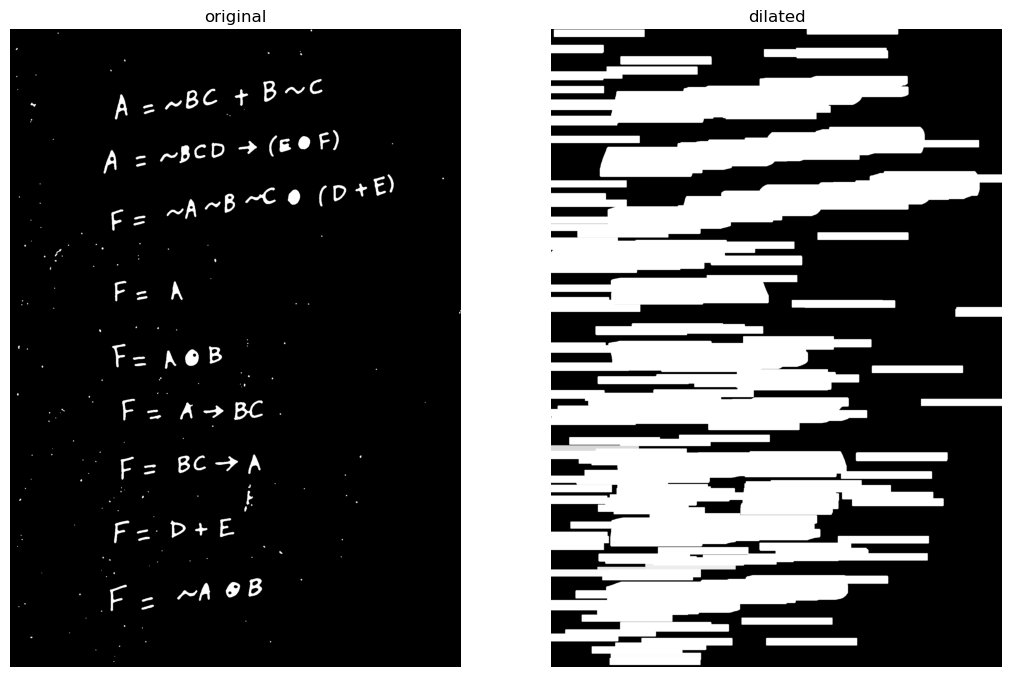

6
ROWS


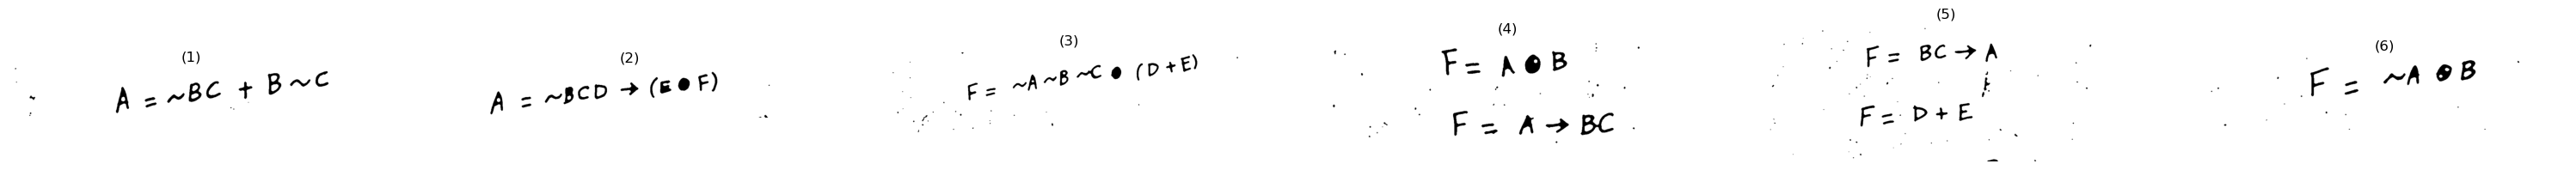

img shape: (205, 1470), max=255, min=0,median=255.0 and type uint8
tolerance: 73.5


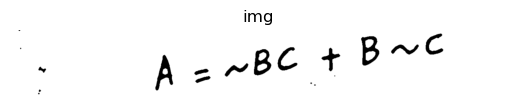

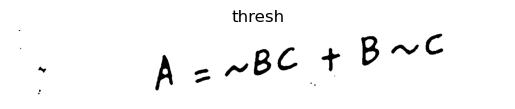

contours before area filtering
22.0, 36.5, 19.5, 17.0, 460.5, 8.0, 444.5, -204.5, 210.0, -413.5, 980.5, 2457.5, -370.0, -571.5, 3042.0, 1227.5, 12.0, 1461.0, 1043.5, -452.5, 3507.5, 1316.5, -299650.5, 
average_area 956.8235294117648
max_width 84
max_height 106
contours after area filtering
500, 5724, 880, 1034, 2952, 4187, 4209, 4118, 4840, 2604, 3402, 
masks


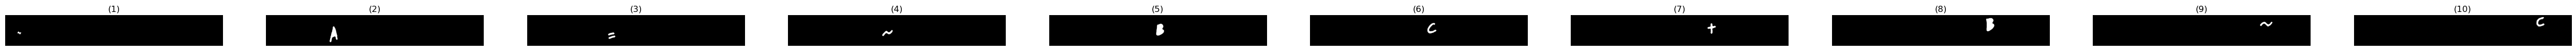

contours after merging


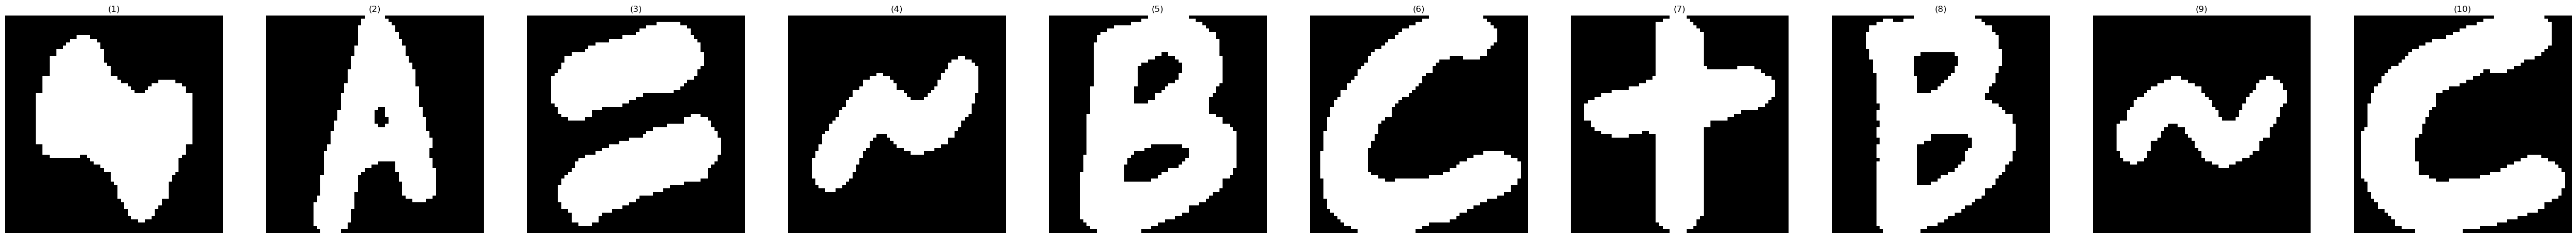

img shape: (207, 1560), max=255, min=0,median=255.0 and type uint8
tolerance: 78.0


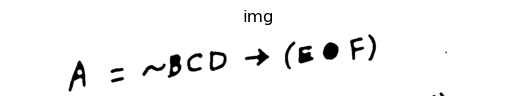

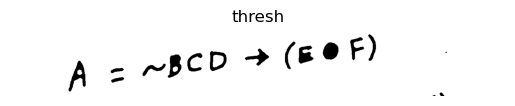

contours before area filtering
432.5, -172.5, 429.5, -196.5, 992.0, 2328.0, -997.0, 2211.5, 1213.0, 19.5, 2686.5, 1522.0, 1789.5, 2133.5, 937.5, 1289.0, 934.0, -321020.0, 
average_area 1351.2857142857142
max_width 78
max_height 99
contours after area filtering
5544, 774, 817, 3075, 3375, 2940, 3510, 4368, 3115, 2842, 2856, 3404, 2322, 
masks


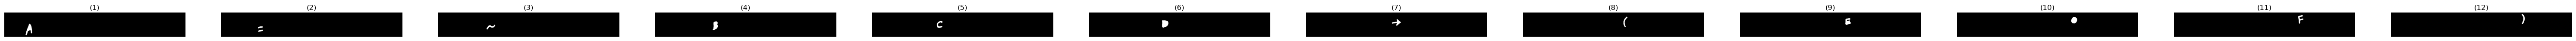

contours after merging


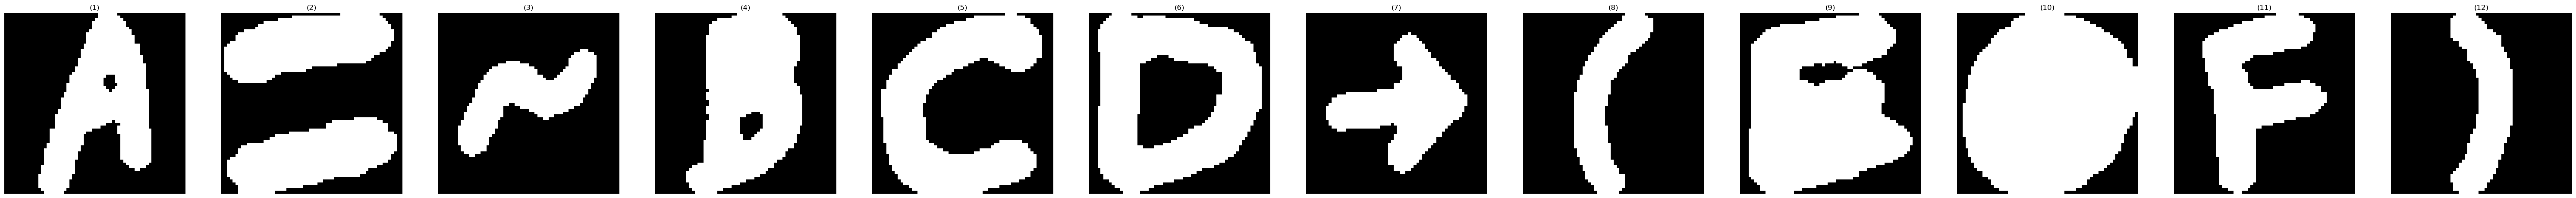

img shape: (419, 1853), max=255, min=0,median=255.0 and type uint8
tolerance: 92.65


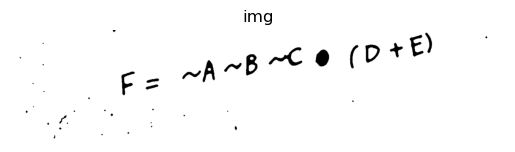

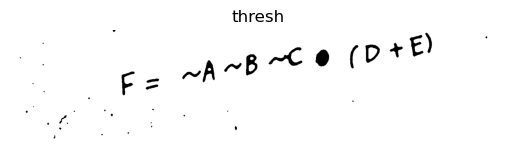

contours before area filtering
58.5, 28.0, 31.5, 54.5, 103.0, 27.0, 24.5, 48.0, 18.5, 239.5, 31.0, 65.0, 16.0, 23.0, 52.0, 32.5, 31.5, 13.5, 25.5, 38.5, 22.0, 470.0, 17.0, 470.5, 1581.5, 852.5, -89.0, -438.0, 24.5, 832.0, 1870.0, 20.5, -107.5, 2661.5, 2438.0, -1008.5, 2442.5, 963.0, 2742.0, 1016.0, 19.5, 47.0, 1779.0, 831.5, -774037.5, 
average_area 551.55
max_width 128
max_height 90
contours after area filtering
112, 990, 120, 4590, 1029, 833, 2448, 3948, 2345, 170, 3564, 8960, 3445, 3026, 3864, 2907, 4536, 2079, 
masks


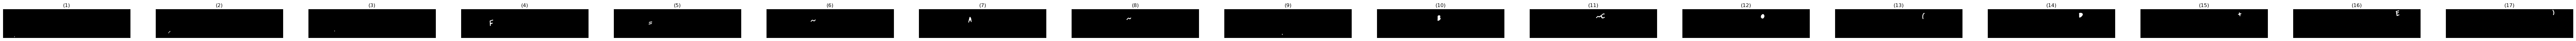

contours after merging


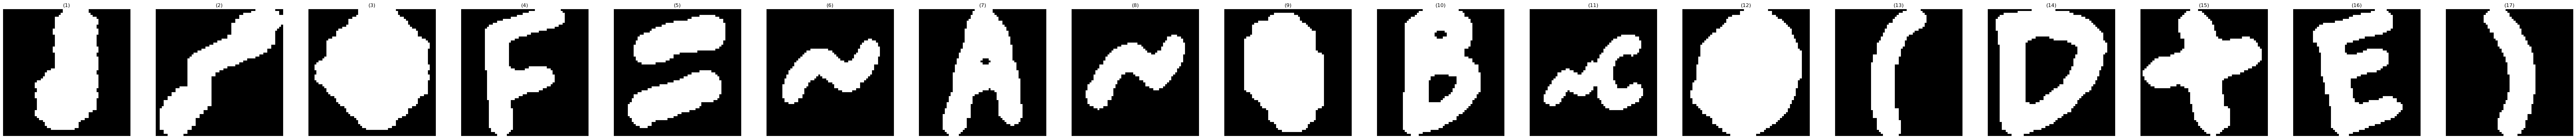

img shape: (387, 1318), max=255, min=0,median=255.0 and type uint8
tolerance: 65.9


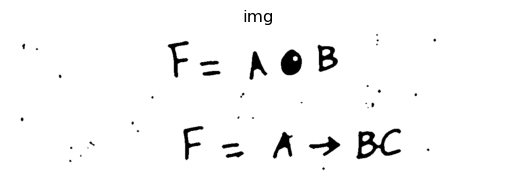

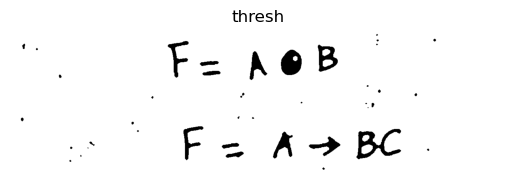

contours before area filtering
34.5, 25.5, 17.5, 498.5, 32.5, 9.5, 36.0, -536.0, 448.0, 77.5, 1545.0, -226.0, 1668.0, 24.0, 4532.0, 1603.0, 45.5, 63.0, 25.5, 30.5, 8.0, 78.0, 16.0, 19.5, 33.5, 28.0, 48.5, 43.0, 55.0, 23.5, 58.0, 482.0, 485.5, -373.0, -112.0, 1530.5, 2975.5, -267.0, 29.0, 2778.5, 18.5, 88.5, 1714.5, 29.0, 46.0, 20.5, -508362.0, 
average_area 520.1219512195122
max_width 121
max_height 99
contours after area filtering
108, 160, 99, 224, 5742, 5060, 795, 714, 816, 900, 3822, 3942, 3933, 4644, 4070, 9922, 126, 99, 
masks


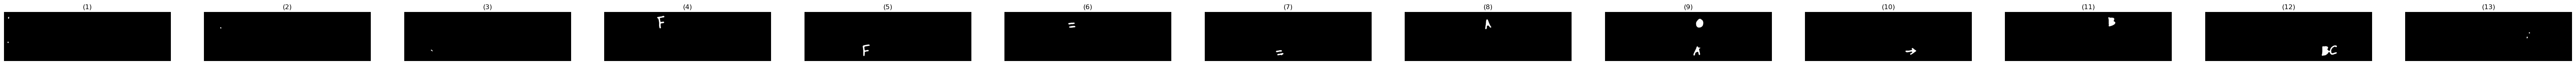

contours after merging


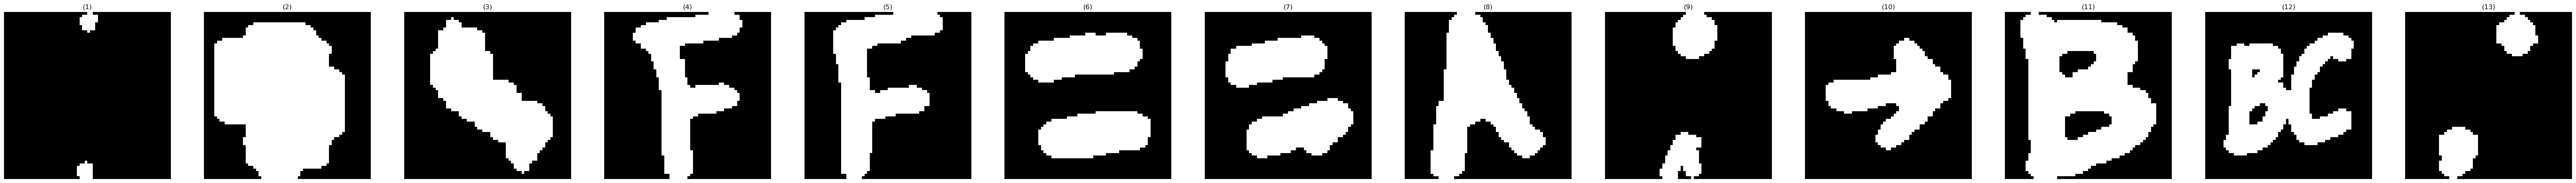

img shape: (600, 1614), max=255, min=0,median=255.0 and type uint8
tolerance: 80.7


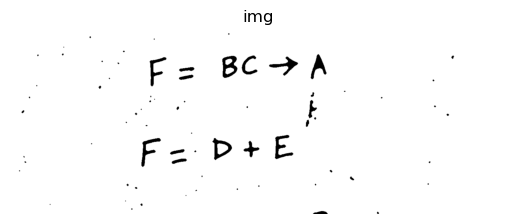

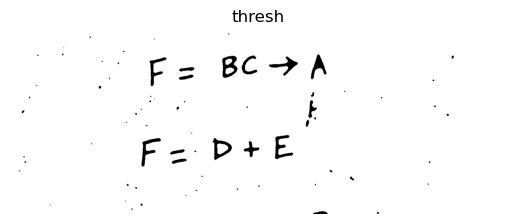

contours before area filtering
22.0, 11.0, 47.5, 9.5, 12.0, 20.0, 22.0, 35.0, 22.0, 19.5, 39.5, 18.5, 106.0, 19.5, 17.0, 58.5, 30.0, 29.0, 485.5, 22.0, 29.0, 473.5, -875.0, 16.0, 972.0, 2740.0, 1797.5, 1862.5, 12.0, 24.0, 16.0, 191.0, 44.0, 48.5, 35.5, 64.5, 14.5, 71.0, 22.0, 33.5, 22.0, 31.5, 717.0, 8.0, 22.0, 24.0, 19.0, 114.5, 17.5, 67.5, 13.5, 31.5, 17.5, 490.0, -404.5, 499.5, 28.0, 17.0, -300.5, 1629.0, 1753.5, 2833.5, 69.0, 1167.0, 19.5, 1636.0, 29.0, 22.0, 7.0, 12.0, 22.0, 17.0, -965834.5, 
average_area 302.45652173913044
max_width 96
max_height 96
contours after area filtering
121, 132, 90, 63, 81, 90, 6175, 56, 5472, 980, 900, 120, 931, 832, 4745, 3723, 3339, 2970, 6240, 4960, 325, 1800, 234, 4399, 80, 110, 240, 56, 64, 90, 143, 
masks


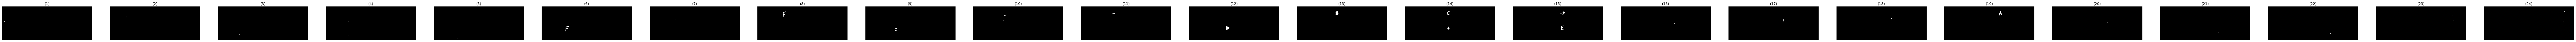

contours after merging


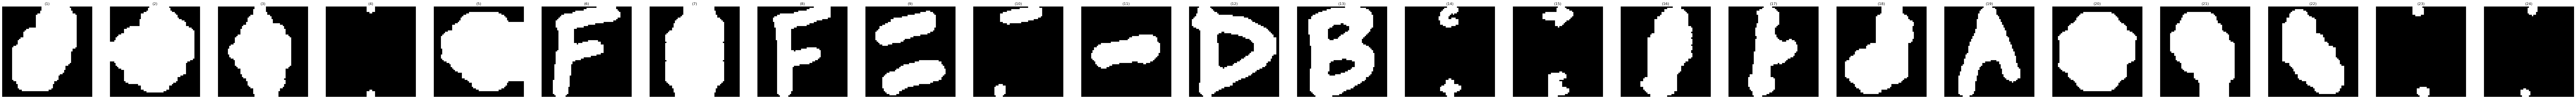

img shape: (274, 1386), max=255, min=0,median=255.0 and type uint8
tolerance: 69.3


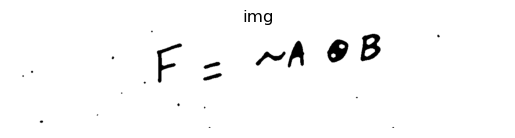

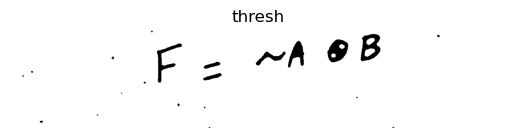

contours before area filtering
50.5, 16.0, 21.0, 43.0, 17.5, 12.0, 30.0, 19.5, 531.5, 29.5, 476.5, 45.5, -99.0, 1157.0, -412.5, -128.0, 1968.0, 1765.5, 2726.5, -281.5, 44.0, 3249.0, 22.0, -378084.5, 
average_area 643.3947368421053
max_width 85
max_height 111
contours after area filtering
8103, 1188, 1029, 3485, 3619, 3900, 4389, 
masks


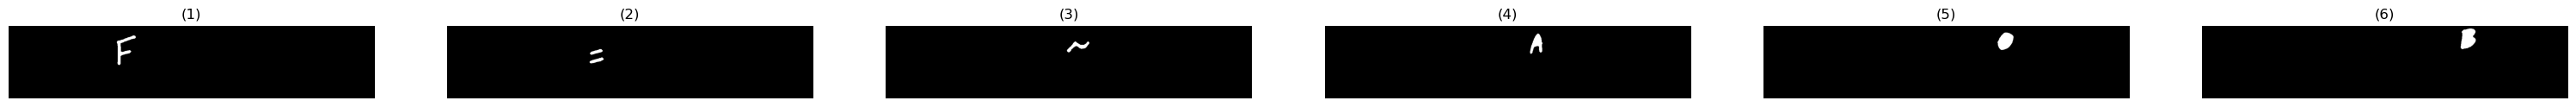

contours after merging


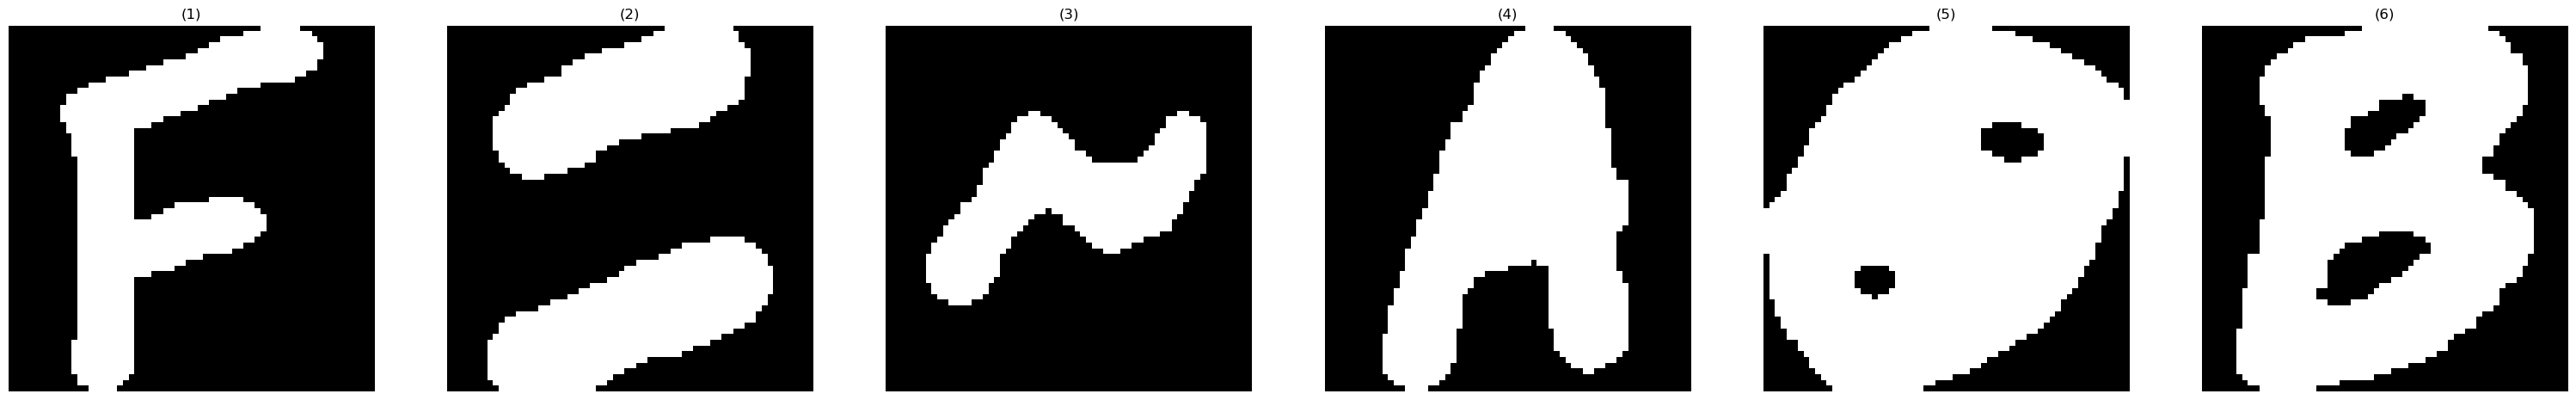

[array(['~', 'A', 'E', '~', 'B', 'C', '+', 'B', '~', 'C'], dtype='<U7'), array(['A', '~', '~', 'D', 'C', 'D', '+', '(', 'E', 'C', 'F', ')'],
      dtype='<U7'), array(['D', 'F', 'C', 'F', 'E', '~', 'A', '~', 'D', 'B', '+', 'C', '(',
       'D', '+', 'B', ')'], dtype='<U7'), array(['~', 'D', '+', 'F', 'F', 'E', 'E', 'A', ')', 'implies', 'B', 'xor',
       '~'], dtype='<U7'), array(['~', 'C', 'C', '~', 'C', 'F', '~', 'F', 'E', '~', 'implies', 'D',
       'B', '~', '~', 'D', 'F', '~', 'A', 'C', 'D', 'D', '~', '~'],
      dtype='<U7'), array(['F', 'E', '~', 'A', 'C', 'D'], dtype='<U7')]
E and ~ B and C or B and ~ C 
~ D and C and D or ( E and C and F ) 
C and F and E and ~ A and ~ D and B or C and ( D or B ) 
or F and F and E and E and A ) implies B xor ~ 
C and ~ C and F and ~ F and E and ~ implies D and B and ~ ~ D and F and ~ A and C and D and D and ~ ~ 
~ A and C and D 
+-----+-----+-----+---------------------------------+
|  B  |  E  |  C  |  E and ~ B and C or B and ~ C   |
|-----+--

IndexError: list index out of range

In [132]:
image = cv2.imread("./test_images/final_test_4.jpg") # TEST R
# image = cv2.imread("./test_images/ex1.jpg")
# image = cv2.imread("./test_images/t2.jpg") # TEST R
# image = cv2.imread("./test_images/exs/t29.jpg") # TEST R
# image = cv2.imread("./test_images/exs/t30.jpg") # TEST R


result = solve_expression(image, is_table=False, showTrace=True)




In [ ]:
# image = cv2.imread("./test_images/exs/t36.jpg") # TEST R
# image = cv2.imread("./test_images/exs/t35.jpg") # TEST R
# # image = cv2.imread("./test_images/exs/t40.jpg") # TEST R


# # image = cv2.imread("./test_images/exs/t34.jpg") # TEST R

# # image = cv2.imread("./test_images/exs/t33.jpg") 
# image = cv2.imread("./test_images/exs/t39.jpg") # TEST R
# # image = cv2.imread("./test_images/exs/t38.jpg") # TEST R

# result = solve_expression(image, is_table=True, showTrace=False)